# Examples

In this notebook we present our novel approach **Instance hardness based label smoothing**. This notebook was ran on a Google Colab Pro TPU, hence the fast training times. For anyone interested to rerun it, we prepared everything for a GPU (which may be a more common way).

In [ ]:
# Training on a GPU / TPU surely helps!

import tensorflow as tf
import pandas as pd
import numpy as np
from pandarallel import pandarallel


# Init pandarallel - for fast DataFrame processing
pandarallel.initialize(progress_bar=True)

# GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

## Dataset

In [9]:
from utils.data import get_test_datasets, encode_and_label

# Set variables
data_path = "./datasets"
dir_path = "."

Load the training and evaluation datasets and preprocess them. Preprocessing consists of taking the `miRNA` and `gene` columns and creating a 2D representation based on Watson-Crick base pairing.

In [10]:
# Load and encode train data
train_pool = pd.read_csv(f"{data_path}/train_set_1_100_CLASH2013_paper.tsv", sep="\t")
train_pool.head()

,miRNA,gene,label
0,TGTAAACATCCTCGACTGGA,GTCGAGAAGTCAACGACTCAATGAAGAATTCCACTTATGGCGTGAA...,1
1,TGAGACCTCTGGGTTCTGAG,GACCTCAGAGCTCCAGGATCATCAGTAAATTTGTCATGTTATATAT...,1
2,GAGGGTTGGGTGGAGGCTCT,TGCCATAATGAACCGTCCAGCCCCTGTGGAGATCTCCTATGAGAAC...,1
3,CAAAGTGCTTACAGTGCAGG,CACCAGAATTGCCAAAGCACATATATAATAAATTAGATAAAGGGCA...,1
4,TTAGGGCCCTGGCTCCATCT,AGCCAAGTGGAGAAGGGTTCCTATCCCTGGCAGGTATCTCTGAAAC...,1


In [11]:
# Encode training data (in a faster way)
train_pool = train_pool.parallel_apply(encode_and_label, axis=1, result_type='expand')
print("\nEncoded training pool")
train_pool.head()


Encoded training pool


,0,1
0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1...",1
1,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1...",1
2,"[[[0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0...",1
3,"[[[0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1...",1
4,"[[[1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0...",1


Column `0` are the encoded sequences with shape (50, 20, 1), column `1` contains the labels.

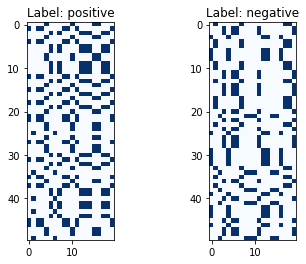

In [ ]:
# Let's visualize the encoding

from utils.visualization import plot_heatmap

positive_sample = train_pool[train_pool[1] == 1].sample(n=1)
negative_sample = train_pool[train_pool[1] == 0].sample(n=1)

plot_heatmap([positive_sample[0].squeeze(), negative_sample[0].squeeze()], ['positive', 'negative'])

Finally we will load the evaluation (or test) sets.

In [ ]:
eval_1, eval_10, eval_100 = get_test_datasets(data_path, dataset_type="evaluation")

## Example 1 - IH by a committee

This example demonstrates the label smoothing process, which is based on instance hardness produced by a committee. This committee has been trained on 1:20 ratio of the undersampled "training pool".

**Committee** consists of:

- 1x ResNet "mini"
- 1x ResNet "small"
- 1x ResNet "large"
- 3x CNN "baseline"

In [ ]:
# Load the IH produced by the committee and add IH scores to train_pool

df_ih = pd.read_csv(f"{data_path}/train_pool_IH_committee.csv")
train_pool['ih'] = df_ih['ih_committee']


The mean IH is just 0.02847453222449047.



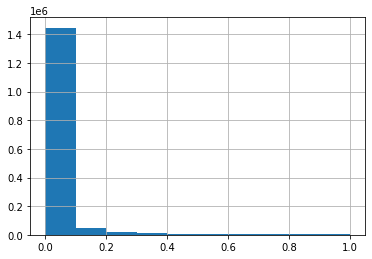

In [ ]:
_ = train_pool['ih'].hist()
print(f"\nThe mean IH is just {train_pool['ih'].mean()}.\n")

Now, we will prepare a training set for our model, which will include all samples harder than 0.1 (or other threshold which select at least some "hard" samples).

In [ ]:
# Prepare undersampled data

IH_THRESHOLD = 0.1
RATIO = 20

positive_samples = train_pool[train_pool[1] == 1]
hard_samples = train_pool[(train_pool[1] == 0) & (train_pool['ih'] > IH_THRESHOLD)]

# Let us sample negative samples in a way that we keep the approx 1:20 ratio
negative_samples = train_pool[train_pool[1] == 0].sample(n=len(positive_samples)*RATIO-len(hard_samples))

# Concatenate and shuffle samples
train_data = pd.concat([
    
    positive_samples,
    hard_samples,
    negative_samples

    ], axis=0).sample(frac=1.0)
train_data.reset_index(inplace=True)
del train_data['index']

print(f"Using {train_data.shape[0]} training samples.")

Using 323232 training samples.


The instance hardness based label smoothing does not stop using the information about IH here. We will use it to smooth the labels of the train_data. This ensures, that the model will be taught to not be overconfident namely when classifying hard samples (in this case samples with IH > 0.5 for example).

In [ ]:
from utils.label_smoothing import get_soft_labels

# Since we assume the committee produced an accurate estimate of IH, we will use a finer smoothing

borders = np.arange(0.0, 1.1, 0.1)
train_data = get_soft_labels(train_data, borders, min_major=0.05, increase=0.05, ih_col="ih", label_col=1)

print("Number of samples with given soft label:")
print(train_data['soft_label'].value_counts())

Number of samples with given soft label:
[0.95, 0.05]                                 205472
[0.9, 0.1]                                    45684
[0.85, 0.15000000000000002]                   23218
[0.05, 0.95]                                  15392
[0.8, 0.2]                                    10441
[0.75, 0.25]                                   7592
[0.7, 0.3]                                     5824
[0.6499999999999999, 0.35000000000000003]      3664
[0.6, 0.4]                                     2630
[0.55, 0.45]                                   2239
[0.5, 0.5]                                     1076
Name: soft_label, dtype: int64


In [ ]:
from utils.architectures.resnet import create_resnet

In [ ]:
model_resnet = create_resnet(name="resnet", size="small", output="softmax")
model_resnet.compile(**{
      "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
      "loss": tf.keras.losses.CategoricalCrossentropy(),
  })

model_resnet.summary()

Model: "resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50, 20, 1)]       0         
                                                                 
 batch_normalization_90 (Bat  (None, 50, 20, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_93 (Conv2D)          (None, 50, 20, 16)        160       
                                                                 
 re_lu_87 (ReLU)             (None, 50, 20, 16)        0         
                                                                 
 batch_normalization_91 (Bat  (None, 50, 20, 16)       64        
 chNormalization)                                                
                                                                 
 dropout_45 (Dropout)        (None, 50, 20, 16)        0    

In [ ]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.0001, 
        patience=20, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

]

When training we will use a fairly large batch size to increase the probability that a batch will contain some positive samples. Setting the `epochs` parameter to 1000 ensures that the training is stopped by early stopping.

In [ ]:
history = model_resnet.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data['soft_label'])), 

    shuffle=True,
    batch_size=128*8,
    validation_split=0.05,

    verbose=1,
    epochs=1000,
    callbacks=callbacks
)

Epoch 1/1000
300/300 [==============================] - 52s 92ms/step - loss: 0.3859 - val_loss: 0.4880
Epoch 2/1000
300/300 [==============================] - 12s 41ms/step - loss: 0.3572 - val_loss: 0.3516
Epoch 3/1000
300/300 [==============================] - 13s 42ms/step - loss: 0.3482 - val_loss: 0.3402
Epoch 4/1000
300/300 [==============================] - 13s 42ms/step - loss: 0.3409 - val_loss: 0.3297
Epoch 5/1000
300/300 [==============================] - 13s 42ms/step - loss: 0.3358 - val_loss: 0.3272
Epoch 6/1000
300/300 [==============================] - 13s 42ms/step - loss: 0.3320 - val_loss: 0.3260
Epoch 7/1000
300/300 [==============================] - 12s 42ms/step - loss: 0.3296 - val_loss: 0.3225
Epoch 8/1000
300/300 [==============================] - 12s 39ms/step - loss: 0.3275 - val_loss: 0.3225
Epoch 9/1000
300/300 [==============================] - 13s 42ms/step - loss: 0.3260 - val_loss: 0.3209
Epoch 10/1000
300/300 [==============================] - 13s 43m

In [ ]:
from utils.testing import test_and_plot

resnet	AP100 = 0.5474006417665209
resnet	AP10 = 0.8338392519421832
resnet	AP1 = 0.9717523876045886


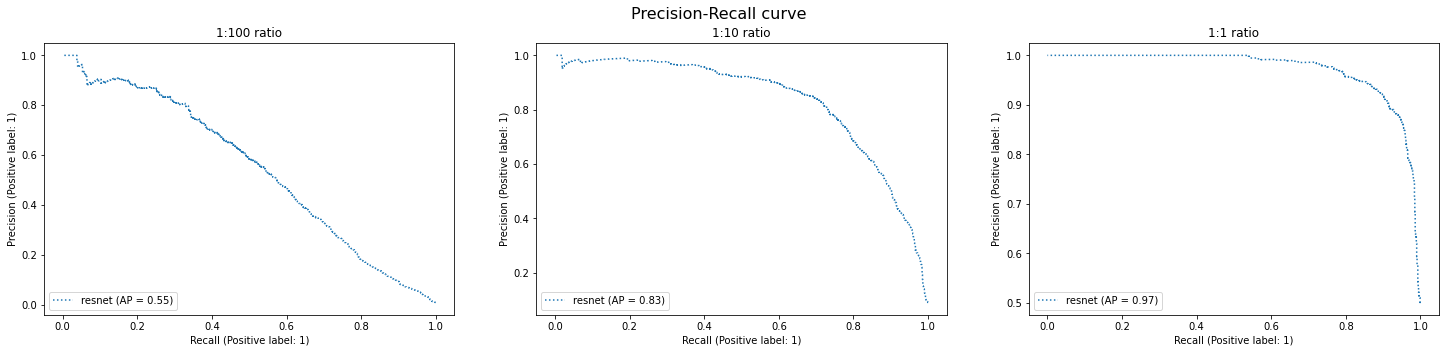

In [ ]:
test_and_plot([model_resnet],
                  eval_1, eval_10, eval_100,
                  combine_method=None,
                  output_activation="softmax",
                  save_preds=0,
                  csv_name="preds",
                  dir_path=".")

In [ ]:
model_resnet.save(f"{dir_path}/models/resnet_small_committee.h5")

## Example 2 - IH by a scout

Scout models are just smaller versions of our main architecture modified for this task. To give an example, a scout model can be easilly created by reducing the number of filters used in the ResNet architecture.

In this experiment we will go through the full pipeline, which is:

- train a scout model
- compute IH for the training pool
- select all hard samples and enrich the main model's training dataset
- smoothen the labels
- train the main model

We will train a smarter scout by giving it the whole dataset later used for the main model.

In [9]:
# Prepare undersampled data

SCOUT_RATIO = 20

# "Fix" the data by choosing a seed
SEED = 3167

positive_samples = train_pool[train_pool[1] == 1]
negative_samples = train_pool[train_pool[1] == 0].sample(n=len(positive_samples)*SCOUT_RATIO, random_state=SEED)

# Concatenate and shuffle samples
train_data = pd.concat([
    
    positive_samples,
    negative_samples

], axis=0).sample(frac=1.0)
train_data.reset_index(inplace=True)
del train_data['index']

print(f"Using {train_data.shape[0]} training samples.")

Using 323232 training samples.


In [14]:
from utils.architectures.resnet import create_resnet

Since we are going to train a scout, we have to change the ResNet size to "mini". This creates a model with less filters in individual layers and sets a lower dropout rate.

In [12]:
scout_resnet = create_resnet(name="scout_resnet", size="mini", output="sigmoid")
scout_resnet.compile(**{
      "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
      "loss": tf.keras.losses.BinaryCrossentropy(),
  })

scout_resnet.summary()

Model: "scout_resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 20, 1)]       0         
                                                                 
 batch_normalization (BatchN  (None, 50, 20, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 50, 20, 8)         80        
                                                                 
 re_lu (ReLU)                (None, 50, 20, 8)         0         
                                                                 
 batch_normalization_1 (Batc  (None, 50, 20, 8)        32        
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 50, 20, 8)        

In [13]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.001, 
        patience=15, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

]

In [14]:
history = scout_resnet.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data[1])), 

    shuffle=True,
    batch_size=128*8,
    validation_split=0.05,

    verbose=1,
    epochs=1000,
    callbacks=callbacks
)

Epoch 1/1000
300/300 [==============================] - 46s 82ms/step - loss: 0.2699 - val_loss: 0.1619
Epoch 2/1000
300/300 [==============================] - 9s 29ms/step - loss: 0.1407 - val_loss: 0.2082
Epoch 3/1000
300/300 [==============================] - 9s 30ms/step - loss: 0.1328 - val_loss: 0.2333
Epoch 4/1000
300/300 [==============================] - 10s 32ms/step - loss: 0.1257 - val_loss: 0.1425
Epoch 5/1000
300/300 [==============================] - 9s 30ms/step - loss: 0.1218 - val_loss: 0.2054
Epoch 6/1000
300/300 [==============================] - 10s 33ms/step - loss: 0.1223 - val_loss: 0.1168
Epoch 7/1000
300/300 [==============================] - 10s 32ms/step - loss: 0.1130 - val_loss: 0.0986
Epoch 8/1000
300/300 [==============================] - 9s 30ms/step - loss: 0.1082 - val_loss: 0.1001
Epoch 9/1000
300/300 [==============================] - 10s 33ms/step - loss: 0.1049 - val_loss: 0.0934
Epoch 10/1000
300/300 [==============================] - 9s 31ms/ste

In [15]:
from utils.testing import test_and_plot

scout_resnet	AP100 = 0.4676923600651887
scout_resnet	AP10 = 0.7996427896497689
scout_resnet	AP1 = 0.9609144215877692


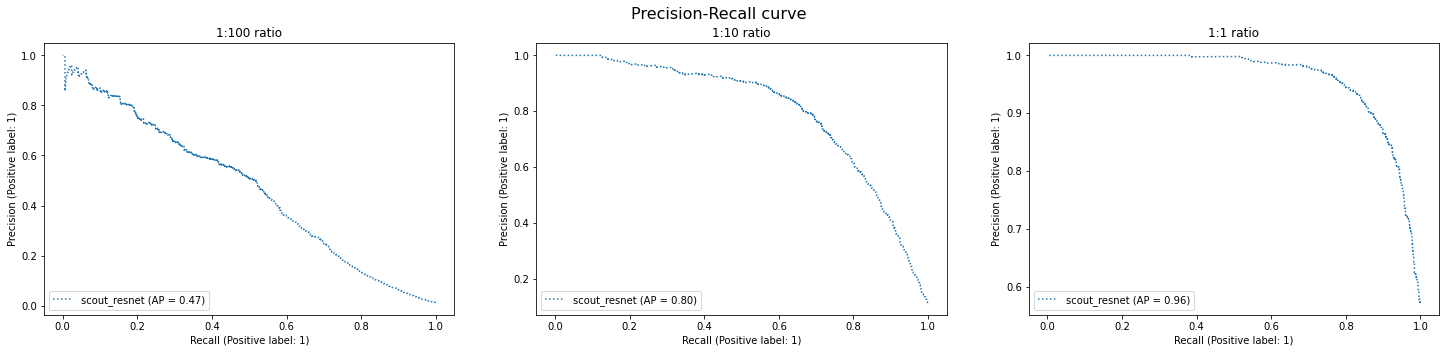

In [16]:
test_and_plot([scout_resnet],
                  eval_1, eval_10, eval_100,
                  combine_method=None,
                  output_activation="sigmoid",
                  save_preds=0,
                  csv_name="preds",
                  dir_path=".")

In [17]:
scout_resnet.save(f"{dir_path}/models/scout_resnet.h5")

The next part is letting the scout model assign IH score to the whole training pool. The steps that follow this one are pretty much identical with the Example 1.

In [16]:
from utils.label_smoothing import get_instances_hardness

In [17]:
train_pool['ih_scout'] = get_instances_hardness(scout_resnet, train_pool, data_col=0, label_col=1, batch_size=100000)
train_pool['ih_scout'] = train_pool['ih_scout'].round(2)

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 51ms/step



The mean IH (produced by a scout) is 0.025249058380723.



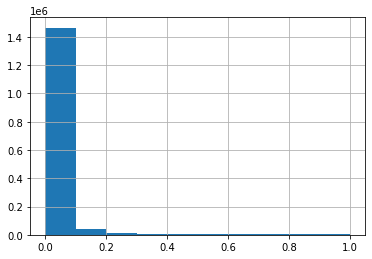

In [18]:
_ = train_pool['ih_scout'].hist()
print(f"\nThe mean IH (produced by a scout) is {train_pool['ih_scout'].mean()}.\n")

Instead of using a specific threshold (as scout would potentially be used in a pipeline without a human intervention in between), we can sort the training pool by 'ih_scout' and take the 100k hardest samples.

In [21]:
# Prepare undersampled data

RATIO = 20
NUM_HARD_SAMPLES = 100000

positive_samples = train_pool[train_pool[1] == 1]
hard_samples = train_pool[train_pool[1] == 0].sort_values('ih_scout')[-NUM_HARD_SAMPLES:]

# Let us sample the negative class in a way that we keep the approx 1:20 ratio
negative_samples = train_pool[train_pool[1] == 0].sample(n=len(positive_samples)*RATIO-len(hard_samples), random_state=SEED)

# Concatenate and shuffle samples
train_data = pd.concat([
    
    positive_samples,
    hard_samples,
    negative_samples

    ], axis=0).sample(frac=1.0)
train_data.reset_index(inplace=True)
del train_data['index']

print(f"Using {train_data.shape[0]} training samples.")

Using 323232 training samples.


In [23]:
from utils.label_smoothing import get_soft_labels

"""
If we used scout trained on smaller ratio, we could use following borders and 
get_soft_label params:

borders = np.arange(0.0, 0.6, 0.1)
train_data = get_soft_labels(train_data, borders, min_major=0.10, increase=0.05, ih_col="ih_scout", label_col=1)

"""

borders = np.arange(0.0, 1.1, 0.1)
train_data = get_soft_labels(train_data, borders, min_major=0.10, increase=0.05, ih_col="ih_scout", label_col=1)

print("Number of samples with given soft label:")
print(train_data['soft_label'].value_counts())

Number of samples with given soft label:
[0.9, 0.1]      219604
[0.85, 0.15]     40350
[0.8, 0.2]       16412
[0.05, 0.95]     15392
[0.75, 0.25]      9114
[0.7, 0.3]        6148
[0.65, 0.35]      4624
[0.6, 0.4]        3825
[0.55, 0.45]      3100
[0.5, 0.5]        2659
[0.45, 0.55]      2004
Name: soft_label, dtype: int64


In [24]:
model_resnet = create_resnet(name="resnet", size="small", output="softmax")
model_resnet.compile(**{
      "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
      "loss": tf.keras.losses.CategoricalCrossentropy(),
  })

model_resnet.summary()

Model: "resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 20, 1)]       0         
                                                                 
 batch_normalization_28 (Bat  (None, 50, 20, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_30 (Conv2D)          (None, 50, 20, 16)        160       
                                                                 
 re_lu_28 (ReLU)             (None, 50, 20, 16)        0         
                                                                 
 batch_normalization_29 (Bat  (None, 50, 20, 16)       64        
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 50, 20, 16)        0    

In [25]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.0001, 
        patience=20, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

]

In [26]:
history = model_resnet.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data['soft_label'])), 

    shuffle=True,
    batch_size=128*8,
    validation_split=0.05,

    verbose=1,
    epochs=1000,
    callbacks=callbacks
)

Epoch 1/1000
300/300 [==============================] - 50s 90ms/step - loss: 0.4625 - val_loss: 0.5299
Epoch 2/1000
300/300 [==============================] - 12s 40ms/step - loss: 0.4411 - val_loss: 0.4585
Epoch 3/1000
300/300 [==============================] - 12s 40ms/step - loss: 0.4351 - val_loss: 0.4309
Epoch 4/1000
300/300 [==============================] - 12s 40ms/step - loss: 0.4304 - val_loss: 0.4280
Epoch 5/1000
300/300 [==============================] - 12s 40ms/step - loss: 0.4259 - val_loss: 0.4198
Epoch 6/1000
300/300 [==============================] - 12s 39ms/step - loss: 0.4225 - val_loss: 0.4188
Epoch 7/1000
300/300 [==============================] - 12s 39ms/step - loss: 0.4201 - val_loss: 0.4148
Epoch 8/1000
300/300 [==============================] - 12s 39ms/step - loss: 0.4184 - val_loss: 0.4146
Epoch 9/1000
300/300 [==============================] - 11s 37ms/step - loss: 0.4170 - val_loss: 0.4153
Epoch 10/1000
300/300 [==============================] - 12s 39m

In [28]:
from utils.testing import test_and_plot

resnet	AP100 = 0.5349144481198534
resnet	AP10 = 0.8280704639329748
resnet	AP1 = 0.9671681781303637


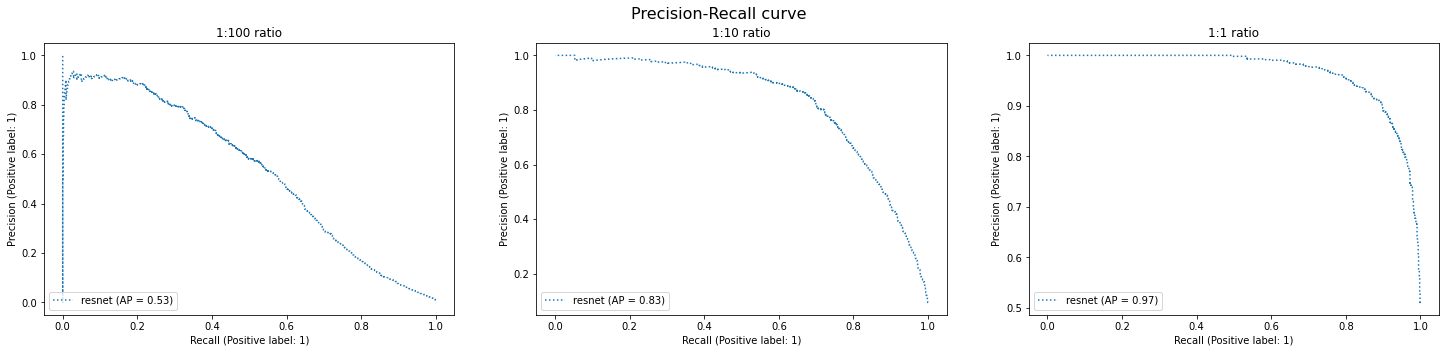

In [29]:
test_and_plot([model_resnet],
                  eval_1, eval_10, eval_100,
                  combine_method=None,
                  output_activation="softmax",
                  save_preds=0,
                  csv_name="preds",
                  dir_path=".")

In [30]:
model_resnet.save(f"{dir_path}/models/resnet_small_scout.h5")